In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import quad
from scipy.special import sph_harm

In [2]:
G = 6.67430e-11 # m^3 kg^-1 s^-2
M = 1e12 # kg

# Multipole Expansion

I want to test the multipole expansion in approximating gravitational potentials. As an example I will first take the Satoh analytic potential and density and then approximate it with the multipole expansion. 

In [3]:
a = 0.1
b = 1

In [4]:
def Phi_s(R, z):
    S = np.sqrt(R**2 + z**2 + a*(a+2*np.sqrt(z**2 + b**2)))
    return -G*M/S

def rho_s(R, z):
    S = np.sqrt(R**2 + z**2 + a*(a+2*np.sqrt(z**2 + b**2)))
    return ( (a*b**2*M) / 4*np.pi*S**3*(z**2 + b**2)) * ( (1/(np.sqrt(z**2 + b**2))) + (3/a)*( 1 - (R**2+z**2)/S**2 ) )

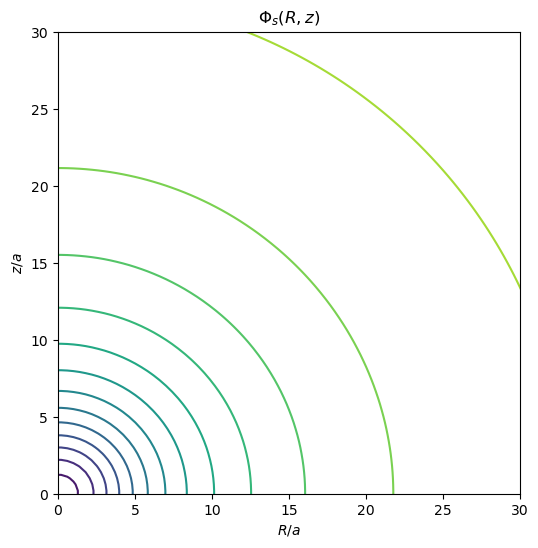

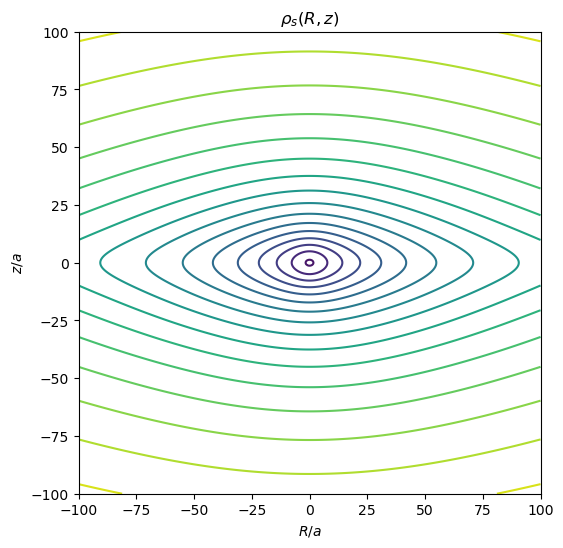

In [10]:
R_list = np.linspace(-10, 10, 500)
z_list = np.linspace(-10, 10, 500)

R, z = np.meshgrid(R_list, z_list)

potential = Phi_s(R, z)
density = rho_s(R, z)

R_norm = R / a
z_norm = z / a

plt.figure(figsize=(6, 6))
plt.contour(R_norm, z_norm, potential, levels=15, cmap='viridis')
plt.xlabel(r'$R/a$')
plt.ylabel(r'$z/a$')
plt.xlim(0,30)
plt.ylim(0,30) 
plt.title(r'$\Phi_s(R, z)$')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

plt.figure(figsize=(6, 6))
plt.contour(R_norm, z_norm, np.log10(density), levels=15, cmap='viridis')
plt.xlabel(r'$R/a$')
plt.ylabel(r'$z/a$')
plt.title(r'$\rho_s(R, z)$')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()



The multipole expansion is

$$ \Phi(r,\Omega) = -4\pi G \sum_{\ell,m} \frac{Y_\ell^m(\Omega)}{2\ell+1}\left(\frac{1}{r^{\ell+1}} \int_0^r da a^{\ell+2}\rho_{\ell m}(a) + r^\ell \int_r^\infty \frac{da}{a^{\ell-1}}\rho_{\ell m}(a)\right)$$

In [25]:
# expanding the potential in spherical harmonics
def rho_lm(l, R, z):
    r = np.sqrt(R**2 + z**2)
    theta = np.arctan2(z, R)
    phi = 0 

    integrad = lambda r, theta: rho_s(r*np.sin(theta), r*np.cos(theta)) * np.sin(theta) * sph_harm(0, l, phi, theta).real 

    return quad(integrad, 0, np.pi, args=(r))[0]

rho_lm(2, 100, 100)

-1400864427773.479

In [51]:
def Phi_multipole(r, theta, lmax=0):
    '''
    Compute the multipole for single r and theta values up to lmax
    Inputs:
        r (float): Radial distance from the center of the galaxy
        theta (float): Polar angle from the z-axis
        lmax (int): Maximum multipole order
    Outputs:
        results (Array): Multipole expansion of the potential
    '''
    prefactor = -4*np.pi*G
    phi = 0
    results = 0

    def compute_term(l, r, theta):

        Y_lm = sph_harm(0, l, phi, theta).real

        first_term = Y_lm / (2*l + 1)

        first_integrand = lambda a: a**(l+2) * rho_lm(l,a*np.sin(theta),a*np.cos(theta))
        second_integrand = lambda a: a**(l-1) * rho_lm(l,a*np.sin(theta),a*np.cos(theta))

        first_integral = quad(first_integrand, 0, r)[0]
        second_integral = quad(second_integrand, r, np.inf)[0]

        return prefactor * first_term * ((1/(r**(l+1)))*first_integral + (r**l)*second_integral)
    
    
    for l in range(0, lmax+1):
        results += compute_term(l, r, theta)

    return results

Phi_multipole(0.1, np.pi, lmax=1)
    

/var/folders/71/rd8s6g0x52sd1l6wnf9_z6_r0000gn/T/ipykernel_60210/913775235.py:25: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  second_integral = quad(second_integrand, r, np.inf)[0]
/var/folders/71/rd8s6g0x52sd1l6wnf9_z6_r0000gn/T/ipykernel_60210/913775235.py:25: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  second_integral = quad(second_integrand, r, np.inf)[0]


np.float64(185061561.03810447)

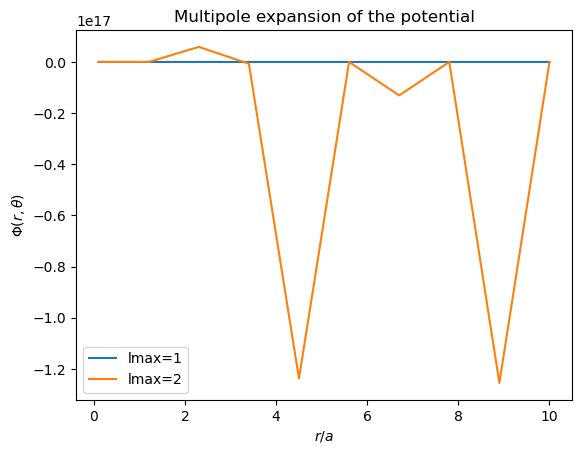

In [55]:
# plot multipoles to see if its working
r = np.linspace(0.1, 10, 10)
theta = np.pi

Phi_results_1 = np.array([Phi_multipole(r, theta, lmax=1) for r in r])
Phi_results_2 = np.array([Phi_multipole(r, theta, lmax=2) for r in r])

plt.plot(r, Phi_results_1, label='lmax=1')
plt.plot(r, Phi_results_2, label='lmax=2')
plt.xlabel(r'$r/a$')
plt.ylabel(r'$\Phi(r, \theta)$')
plt.title(r'Multipole expansion of the potential')
plt.legend()
plt.show()


In [50]:
# check the integrand causing issues with integration 
l = 1

theta = 0
r = 10

integrand = lambda a: a**(l-1) * rho_lm(l,a*np.sin(theta),a*np.cos(theta))

# plt.plot(np.linspace(0, 10, 100), [integrand(a) for a in np.linspace(0, 10, 100)])
# plt.show()

integrate = quad(integrand, r, np.inf)[0]

print(integrate)

-1.6693492882539386e+16


/var/folders/71/rd8s6g0x52sd1l6wnf9_z6_r0000gn/T/ipykernel_60210/3546355353.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrate = quad(integrand, r, np.inf)[0]


In [41]:
r_values = np.linspace(0.1, 20, 100)  # Radial distances from 0.1 to 20
theta_values = np.linspace(0, np.pi, 100)  # Polar angles from 0 to π
R_grid, theta_grid = np.meshgrid(r_values, theta_values)  # Create a meshgrid

# Prepare an array to hold the results
potential_grid = np.zeros(R_grid.shape)

# Calculate the potential for each combination of r and theta
for i in range(R_grid.shape[0]):  # Iterate over the rows
    for j in range(R_grid.shape[1]):  # Iterate over the columns
        r = R_grid[i, j]
        theta = theta_grid[i, j]
        potential_grid[i, j] = Phi_multipole(r, theta, lmax=1) 

/var/folders/71/rd8s6g0x52sd1l6wnf9_z6_r0000gn/T/ipykernel_60210/610019106.py:27: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  second_integral = quad(second_integrand, r, np.inf)[0]
/var/folders/71/rd8s6g0x52sd1l6wnf9_z6_r0000gn/T/ipykernel_60210/610019106.py:27: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  second_integral = quad(second_integrand, r, np.inf)[0]


KeyboardInterrupt: 

In [ ]:
# Convert to R and z
R = R_grid * np.sin(theta_grid)  # R = r * sin(theta)
z = R_grid * np.cos(theta_grid)   # z = r * cos(theta)

# Plotting in the R-z plane
plt.figure(figsize=(10, 6))
contour = plt.contourf(R, z, potential_grid, levels=15, cmap='viridis')
plt.colorbar(label='Potential')
plt.title('Multipole Potential in R-z Plane')
plt.xlabel('R')
plt.ylabel('z')
plt.grid()
plt.show()

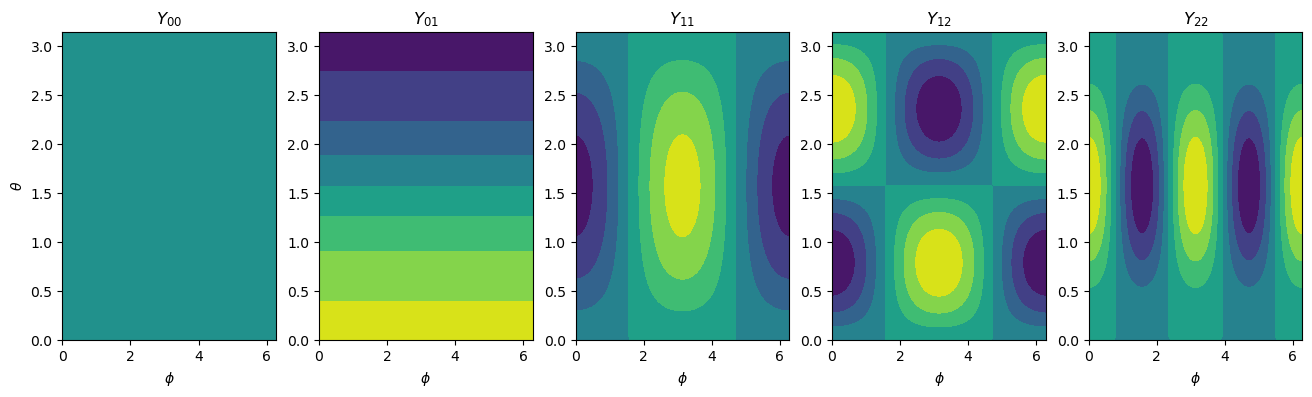

In [87]:
# testing spherical harmonics
theta = np.linspace(0, np.pi, 100)
phi = np.linspace(0, 2*np.pi, 100)
theta, phi = np.meshgrid(theta, phi)

Y00 = sph_harm(0, 0, phi, theta)
Y01 = sph_harm(0, 1, phi, theta)
Y11 = sph_harm(1, 1, phi, theta)
Y12 = sph_harm(1, 2, phi, theta)
Y22 = sph_harm(2, 2, phi, theta)

fig, axs = plt.subplots(1, 5, figsize=(16, 4))

axs[0].contourf(phi, theta, np.real(Y00), cmap='viridis')
axs[0].set_title(r'$Y_{00}$')
axs[0].set_xlabel(r'$\phi$')
axs[0].set_ylabel(r'$\theta$')

axs[1].contourf(phi, theta, np.real(Y01), cmap='viridis')
axs[1].set_title(r'$Y_{01}$')
axs[1].set_xlabel(r'$\phi$')

axs[2].contourf(phi, theta, np.real(Y11), cmap='viridis')
axs[2].set_title(r'$Y_{11}$')
axs[2].set_xlabel(r'$\phi$')

axs[3].contourf(phi, theta, np.real(Y12), cmap='viridis')
axs[3].set_title(r'$Y_{12}$')
axs[3].set_xlabel(r'$\phi$')

axs[4].contourf(phi, theta, np.real(Y22), cmap='viridis')
axs[4].set_title(r'$Y_{22}$')
axs[4].set_xlabel(r'$\phi$')


plt.show()


In [72]:
# Satoh density function in cylindrical coordinates
def rho_s(R, z):
    S = np.sqrt(R**2 + z**2 + a * (a + 2 * np.sqrt(z**2 + b**2)))
    return ( (a * b**2 * M) / (4 * np.pi * S**3 * (z**2 + b**2))) * (
        (1 / np.sqrt(z**2 + b**2)) + (3 / a) * (1 - (R**2 + z**2) / S**2)
    )

# Function to calculate the density from the multipole expansion
def density_multipole_approx(R, z, l_max):
    r = np.sqrt(R**2 + z**2)  # Convert cylindrical coordinates to spherical
    density_approx = 0.0

    for l in range(l_max + 1):
        for m in range(-l, l + 1):
            # Integrate Y_lm over θ and φ
            integral_Ylm = quad(lambda theta: quad(lambda phi: sph_harm(m, l, phi, theta) * np.sin(theta), 0, 2 * np.pi)[0], 0, np.pi)[0]

            # Integral for the inner part
            integral_inner = quad(lambda a: a**(l + 2) * rho_s(a, z), 1e-3, r)[0]

            # Integral for the outer part with a finite upper limit
            outer_limit = 100
            integral_outer = quad(lambda a: rho_s(a, z) / a**(l - 1), r + 1e-3, outer_limit)[0]

            # Include the -4πG factor in the approximation
            density_approx += (-4 * np.pi * G * integral_Ylm / (2 * l + 1)) * (
                (1 / r**(l + 1)) * integral_inner + r**l * integral_outer
            )

    return density_approx

Code currently doesnt run

In [73]:
# Generate values for R/a and z/a
R_a_values = np.linspace(-10, 10, 100)  # R/a range
z_a_values = np.linspace(-10, 10, 100)  # z/a range
R_a, z_a = np.meshgrid(R_a_values, z_a_values)

# Compute densities for the Satoh model and multipole approximation
satoh_density = np.array([[rho_s(R, z) for z in z_a_values] for R in R_a_values])
multipole_density = np.array([[density_multipole_approx(R, z, l_max=3) for z in z_a_values] for R in R_a_values])

# Plotting the contours for Satoh density
plt.figure(figsize=(12, 6))
contour = plt.contourf(R_a, z_a, satoh_density, levels=50, cmap='viridis')
plt.colorbar(label='Density (Satoh)')
plt.title('Contour Plot of Satoh Density in R/a and z/a')
plt.xlabel('R/a')
plt.ylabel('z/a')
plt.grid()
plt.show()

# Plotting the contours for Multipole density approximation
plt.figure(figsize=(12, 6))
contour = plt.contourf(R_a, z_a, multipole_density, levels=50, cmap='plasma')
plt.colorbar(label='Density (Multipole Approximation)')
plt.title('Contour Plot of Multipole Density Approximation in R/a and z/a')
plt.xlabel('R/a')
plt.ylabel('z/a')
plt.grid()
plt.show()

/Users/adamsmith/opt/anaconda3/envs/physenv/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:606: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


KeyboardInterrupt: 